## **Basic Setup**

In [74]:
import itertools
import networkx as nx
from Profile import ProfileEntry, Profile
import math
from copy import deepcopy
import time
import matplotlib.pyplot as plt

In [75]:
def parse_sushi_data(sushi_file):
    """
    Parse the sushi file data
    :param file: location of data
    :return: profile (Profile type) of the sushi database
    """
    with open(sushi_file, 'r') as file:
        lines = file.readlines()[22:]
        entries = []
        for line in lines:
            count, order = line.split(':')
            count = int(count)
            order = [c for c in order.strip().split(',')]
            entries.append(ProfileEntry(count, order))
        return Profile(entries[0].order, entries)

## **Plurality with Runoff**

In [76]:
def psr(profile, alpha, return_scores=False, plurality_with_runoff=False):
    """
    Bonus- General PSR voting rule. For full bonus points, use this function to implement Plurality, Veto and Borda
            with the appropriate score vector alpha.
    :param profile(Profile): profile of voters
    :param alpha(Iterable): score vector of length (at least) profile.m
    :param return_scores(bool): if True, return the scores of each candidate
    :param plurality_with_runoff(bool): if True, return the winners that move on to the second round in plurality with runoff
    :return: the winner of profile by f^PSR_alpha with lexicographic tie-breaking
    """
    m = len(profile.candidates)
    scores = {c : 0 for c in profile.candidates}

    for entry in profile.entries:
        for i, c in enumerate(entry.order):
            scores[c] += entry.count * alpha[i]
    max_score = max(scores.values())
    winners = [c for c in profile.candidates if scores[c] == max_score]

    if not plurality_with_runoff:
        if return_scores:
            return min(winners), scores
        return min(winners)

    if len(winners) == 1:
        second_max_score = max([score for score in scores.values() if score != max_score])
        second_winners = [c for c in profile.candidates if scores[c] == second_max_score]
        second_winners = sorted(second_winners)
        if return_scores:
            return [winners[0], second_winners[0]], scores
        return [winners[0], second_winners[0]]
    
    winners = sorted(winners)
    if return_scores:
        return winners[:2], scores
    return winners[:2] # return the first two winners in lexicographic order


def plurality(profile, return_scores=False, with_runoff=False):
    """
    :param profile(Profile): profile of voters
    :return: the winner of profile by Plurality with lexicographic tie-breaking
    """
    m = len(profile.candidates)
    alpha = [1] + [0] *  (m - 1)
    return psr(profile, alpha, return_scores, with_runoff)


def plurality_with_runoff(profile):
    finalists = plurality(profile, with_runoff=True)
    scores = {w : 0 for w in finalists}
    for entry in profile.entries:
        if entry.order.index(finalists[0]) < entry.order.index(finalists[1]):
            scores[finalists[0]] += entry.count
        else:
            scores[finalists[1]] += entry.count

    if scores[finalists[0]] > scores[finalists[1]]:
        return finalists[0]
    elif scores[finalists[0]] < scores[finalists[1]]: 
        return finalists[1]
    else:
        return min(finalists)

## **Algorithm 2**

In [78]:
def algorithm_2(candidates, p, scores, weights, alpha, return_scores=False):
    """
    Algorithm 2 from the paper - Return if a borda manupulation exists under the explained conditions
    :param candidates: list of candidates
    :param p: manipulation candidate
    :param scores: dictionary of scores for each candidate
    :param weights: weight list for the manipulators
    :param alpha: score vector
    :return: True if a borda manipulation exists (under conditions), False otherwise
    """
    n = len(weights)
    contendors = [c for c in candidates if c != p]
    scores = deepcopy(scores)

    for j in range(n):
        scores[p] += weights[j] * alpha[0]

        # vote for the rest of the candidates in the reverse order of their current scores
        for i, c in enumerate(sorted(contendors, key=lambda c: scores[c])):
            if c == p:
                continue
            scores[c] += weights[j] * alpha[i + 1]
        
    # check if p is the winner
    winner_score = max([scores[c] for c in candidates if c != p])
    winner = min([c for c in candidates if scores[c] == winner_score and c != p])
    if scores[p] > winner_score or (scores[p] == winner_score and p < winner):
        if return_scores:
            return True, scores
        return True
    
    if return_scores:
        return False, scores
    
    return False
    

### **Example from the Article**

In [79]:
def article_example(weights):   
    candidates = [1, 2, 3, 4, 5, 6, 'p']
    p = 'p'
    entries = [
        ProfileEntry(3, [6, 5, 4, 3, 2, 'p', 1]),
        ProfileEntry(2, [2, 3, 4, 5, 6, 'p', 1]),
    ]
    profile = Profile(candidates, entries)

    alpha = [i - 1 for i in range(len(candidates), 0, -1)]

    winner, scores = psr(profile, alpha, return_scores=True)

    print("Initial Borda scores: {}".format(scores))
    print("Initial Borda winner: {}".format(winner))  

    result, final_scores = algorithm_2(candidates, p, scores, weights, alpha, return_scores=True)
    
    return result, final_scores

In [80]:
result, final_scores = article_example([1, 1, 1, 1])
print("Final Borda scores: {}".format(final_scores))
print("Borda manipulation exists: {}".format(result))

Initial Borda scores: {1: 0, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 'p': 5}
Initial Borda winner: 6
Final Borda scores: {1: 20, 2: 30, 3: 29, 4: 28, 5: 27, 6: 26, 'p': 29}
Borda manipulation exists: False


In [81]:
result, final_scores = article_example([1, 1, 1, 1, 1])
print("Final Borda scores: {}".format(final_scores))
print("Borda manipulation exists: {}".format(result))

Initial Borda scores: {1: 0, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 'p': 5}
Initial Borda winner: 6
Final Borda scores: {1: 25, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 'p': 35}
Borda manipulation exists: True


In [82]:
# check if a borda manipulation exists
sushi_profile = parse_sushi_data("data/00014-00000001.soc")
candidates = sushi_profile.candidates
p = '1'
weights = [1163]
alpha = [1] + [0] * 9
winner, scores = psr(sushi_profile, alpha, return_scores=True)

print("Winner: {}".format(winner))
print("Scores: {}".format(scores))

print("Plurality manipulation exists: {}".format(algorithm_2(candidates, p, scores, weights, alpha)))

Winner: 7
Scores: {'7': 1713, '4': 747, '5': 545, '1': 550, '10': 458, '2': 404, '8': 113, '3': 228, '9': 36, '6': 206}
Plurality manipulation exists: True


In [83]:
candidates = [1, 2, 3, 4, 5, 6, 'p']
p = 'p'
entries = [
    ProfileEntry(3, [6,5,4,3,2,'p',1]),
    ProfileEntry(2, [2,3,4,5,6,'p',1]),
]
weights = [1,1,1,1]
alpha = [6,5,4,3,2,1,0]
profile = Profile(candidates, entries)
winner, scores = psr(profile, alpha, return_scores=True)

print("Winner: {}".format(winner))
print("Scores: {}".format(scores))

print("Plurality manipulation exists: {}".format(algorithm_2(candidates, p, scores, weights, alpha)))


Winner: 6
Scores: {1: 0, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 'p': 5}
Plurality manipulation exists: False


## **Algorithm 3**

In [84]:
def subset_of_weights_approximate(wt, diff_g, u):
    """
    Approximate the subset of weights that allow manipulation
    Solve using dynamic programming
    :param wt: list of weights
    :param diff_g: difference between g and g' that we want to achieve
    :param u: size of error window
    :return: x - binary vector that indicates what weights to use
    """
    if u < 0 or u > max(wt):
        return None
    
    n = len(wt)
    x = [0] * n
    ku = math.floor(u / (2 * n)) + 1

    # maximum weight that can be used
    capacity = sum(wt) - diff_g
    # dp table
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]


    # construct the dp table
    for i in range(1, n + 1):
        # weight of the current candidate
        w_i = wt[i - 1]
        mult_val = math.floor(w_i / ku)
        for j in range(1, capacity + 1):
            # if the weight can be used
            if w_i <= j:
                dp[i][j] = max(dp[i - 1][j], mult_val + dp[i - 1][j - w_i])
            else:
                dp[i][j] = dp[i - 1][j]
    

    # find the subset of weights that can be used
    x = [0] * n
    for i in range(n, 0, -1):
        mult_val = math.floor(wt[i - 1] / ku)
        if capacity >= wt[i - 1] and dp[i][capacity] == dp[i - 1][capacity - wt[i - 1]] + mult_val:
            x[i - 1] = 1
            capacity -= wt[i - 1]
    
    final_weights = [1 if x[i] == 0 else 0 for i in range(n)]
    return final_weights

### **Our Improvement - Reducing the Problem Using GCD**

In [85]:
def gcd(W : list):
    """
    Compute the greatest common divisor of a list of integers
    """
    if len(W) == 0:
        return 0
    result = W[0]
    for i in range(1, len(W)):
        result = math.gcd(result, W[i])
        if result == 1:
            return 1
    return result


def reduce_weights_and_entries(ws: list, wt: list, profile: Profile) -> tuple:
    """
    Reduce the weights of two lists by their combined GCD and adjust the ProfileEntry counts accordingly.
    
    :param weights1: First list of weights (voter weights)
    :param weights2: Second list of weights (manipulator weights)
    :param profile: Original profile with entries to be adjusted
    :return: Tuple containing the reduced weights1, weights2, and adjusted Profile object
    """
    combined_weights = ws + wt
    common_gcd = gcd(combined_weights)

    if common_gcd > 1:
        # Divide each weight by the GCD
        ws = [w // common_gcd for w in ws]
        wt = [w // common_gcd for w in wt]
        
        # Adjust the profile entry counts by dividing by the GCD
        adjusted_entries = [ProfileEntry(ws[i], entry.order) for i, entry in enumerate(profile.entries)]
        profile = Profile(profile.candidates, adjusted_entries)

    return ws, wt, profile

In [101]:
def algorithm_3(candidates, p, profile, ws, wt, u, gcd: bool = False, return_x: bool = False):
    """
    Algorithm 3 from the paper - Return if a P.W.R manipulation exists under the explained conditions.
    Optimized to reduce both weight lists and profile entry counts by their combined GCD.
    
    :param candidates: list of candidates
    :param p: manipulation candidate
    :param profile: voter preferences profile
    :param ws: weight list for the voters
    :param wt: weight list for the manipulators
    :param u: error window parameter
    """
    # Reduce both ws and wt using their combined GCD
    if gcd:
        ws, wt, profile = reduce_weights_and_entries(ws, wt, profile)

    competitors = [c for c in candidates if c != p]
    n = len(wt)
    m = len(ws)
    winners, scores = plurality(profile, return_scores=True, with_runoff=True)
    winner, winner_score = winners[0], scores[winners[0]]
    print(f'winner = {winner}, winner_score = {winner_score}')

    if winners[0] == p:
        return True

    for g in competitors:
        print(f'g = {g}')
        new_prof = deepcopy(profile)
        g_score = scores[g]

        if winner < g:
            diff_g = winner_score - g_score + 1
        else:
            diff_g = winner_score - g_score
        print(f'diff_g = {diff_g}')

        if diff_g > sum(ws):
            continue

        x = subset_of_weights_approximate(wt, diff_g, u)
        if x is None:
            continue

        # All manipulators in the subset vote for g, the rest vote for p
        order_g = [g, p] + [c for c in competitors if c != g and c != p]
        order_p = [p, g] + [c for c in competitors if c != g and c != p]
        for j in range(n):
            if x[j] == 1:
                new_prof.entries.append(ProfileEntry(wt[j], order_g))
            else:
                new_prof.entries.append(ProfileEntry(wt[j], order_p))

        # Check if p makes it to the next round
        new_res = plurality(new_prof)
        if p not in new_res:
            continue

        # Check pairwise comparison between p and g
        count_p = count_g = 0
        for entry in new_prof.entries:
            if entry.order.index(p) < entry.order.index(g):
                count_p += entry.count
            else:
                count_g += entry.count
        if count_p > count_g:
            if return_x:
                return True, x
            return True

    if return_x:
        return False, x
    return False

## **Example**

In this example we conduct 3 tests to check if our implementation of algorithm 3 works.

In [102]:
candidates = [1, 2, 3, 4]
p = 3
entries = [
    ProfileEntry(4, [1, 2, 3, 4]),
    ProfileEntry(3, [2, 3, 4, 1]),  
    ProfileEntry(2, [3, 4, 1, 2]),
    ProfileEntry(1, [4, 1, 2, 3])
]
profile = Profile(candidates, entries)
ws = [entry.count for entry in profile.entries]
wt = [1, 1, 1]
u = 0

print('Current winner by Plurality with Runoff:', plurality_with_runoff(profile)) 
print('Plurality with Runoff manipulation exists:', algorithm_3(candidates, p, profile, ws, wt, u))

Current winner by Plurality with Runoff: 1
winner = 1, winner_score = 4
g = 1
diff_g = 0
Final weights: [0, 0, 0]


TypeError: argument of type 'int' is not iterable

In [87]:
def test_algorithm3(scale: int = 1, gcd: bool = False):
    # Define common variables
    candidates = ['A', 'B', 'C', 'D']
    p = 'C'  # The candidate we want to manipulate to win
    
    # Test 1: Manipulation is possible
    entries_test1 = [
        ProfileEntry(scale*4, ['A', 'B', 'C', 'D']),
        ProfileEntry(scale*3, ['B', 'C', 'D', 'A']),
        ProfileEntry(scale*2, ['C', 'D', 'A', 'B']),
        ProfileEntry(scale*1, ['D', 'A', 'B', 'C']),
    ]
    profile_test1 = Profile(candidates, entries_test1)
    ws_test1 = [entry.count for entry in entries_test1]
    wt_test1 = [scale*1, scale*1, scale*1, scale*1]  
    u_test1 = 0
    # print("Winner by Plurality with Runoff in Test 1: {}".format(plurality_with_runoff(profile_test1)))

    # Test 2: Manipulation is possible
    entries_test2 = [
        ProfileEntry(scale*6, ['B', 'C', 'D', 'A']),
        ProfileEntry(scale*4, ['C', 'D', 'A', 'B']),
        ProfileEntry(scale*5, ['D', 'A', 'B', 'C']),
        ProfileEntry(scale*5, ['A', 'B', 'C', 'D']),
    ]
    profile_test2 = Profile(candidates, entries_test2)
    ws_test2 = [entry.count for entry in entries_test2]  
    wt_test2 = [scale*1, scale*1, scale*1, scale*1]
    u_test2 = 0
    # print("Winner by Plurality with Runoff in Test 2: {}".format(plurality_with_runoff(profile_test2)))

    # Test 3: Edge case of manipulation
    entries_test3 = [
        ProfileEntry(scale*10, ['B', 'C', 'D', 'A']),
        ProfileEntry(scale*10, ['C', 'D', 'A', 'B']),
        ProfileEntry(scale*10, ['D', 'B', 'A', 'C']),
        ProfileEntry(scale*10, ['A', 'B', 'C', 'D']),
    ]
    profile_test3 = Profile(candidates, entries_test3)
    ws_test3 = [entry.count for entry in entries_test3]
    wt_test3 = [scale*1, scale*1, scale*1, scale*1]  # on the edge weights
    u_test3 = 0
    # print("Winner by Plurality with Runoff in Test 3: {}".format(plurality_with_runoff(profile_test3)))

    # Run the algorithm on these test cases
    result1 = algorithm_3(candidates, p, profile_test1, ws_test1, wt_test1, u_test1, gcd=gcd)
    
    start_2 = time.time()
    result2 = algorithm_3(candidates, p, profile_test2, ws_test2, wt_test2, u_test2, gcd=gcd)
    end_2 = time.time()
    
    result3 = algorithm_3(candidates, p, profile_test3, ws_test3, wt_test3, u_test3, gcd=gcd)
    
    # print("Test 1:", result1)
    # print("Test 2:", result2)
    # print("Test 3:", result3)
    return end_2 - start_2

In [88]:
scales = list(range(10, 10000, 100))
times = []
for i, scale in enumerate(scales):
    times.append(test_algorithm3(scale))

winner = A, winner_score = 40
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 60
g = A
diff_g = 10
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 100
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 440
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 660
g = A
diff_g = 110
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 1100
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 840
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 1260
g = A
diff_g = 210
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 2100
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 1240
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 1860
g = A
diff_g = 310
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 3100
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 1640
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]


In [89]:
scales = list(range(10, 10000, 100))
times_gcd = []
for i, scale in enumerate(scales):
    times_gcd.append(test_algorithm3(scale, gcd=True))

winner = A, winner_score = 4
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 10
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 4
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 10
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 4
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 10
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 4
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
winner = A, winner_score = 10
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = A, winner_score = 4
g = A
diff_g = 0
Final weights: [0, 0, 0, 0]
winner = B, winner_score = 6
g = A

Text(0.5, 1.0, 'Algorithm 3 GCD vs No GCD')

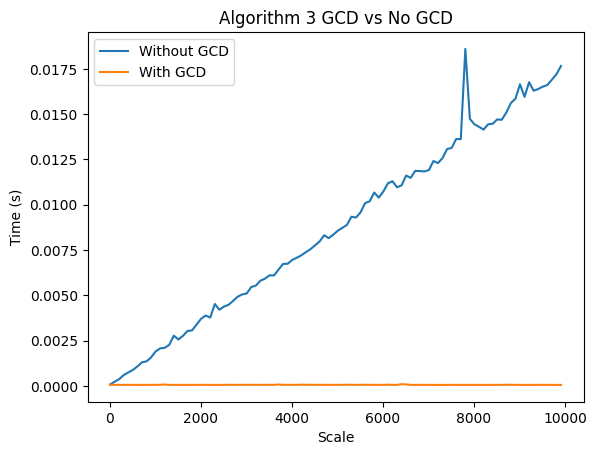

In [90]:
# Plot the results
plt.plot(scales, times, label="Without GCD")
plt.plot(scales, times_gcd, label="With GCD")
plt.xlabel("Scale")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Algorithm 3 GCD vs No GCD")

## **Comparison of the Algorithm with and without GCD (Jonathan's Approch)**

In [91]:
def test_alg3(k: int = 1, gcd: bool = False):
    p = 'C'
    candidates = ['A', 'B', 'C', 'D']
    entries_test2 = [
            ProfileEntry(k * 6, ['B', 'C', 'D', 'A']),
            ProfileEntry(k * 4, ['C', 'D', 'A', 'B']),
            ProfileEntry(k * 5, ['D', 'A', 'B', 'C']),
            ProfileEntry(k * 5, ['A', 'B', 'C', 'D']),
        ]
    profile_test2 = Profile(candidates, entries_test2)
    ws_test2 = [entry.count for entry in entries_test2]  
    wt_test2 = [k * 1, k * 1, k * 1, k * 1]
    u_test2 = 0
    start_2 = time.time()
    result2 = algorithm_3(candidates, p, profile_test2, ws_test2, wt_test2, u_test2, gcd=gcd)
    end_2 = time.time()
    return end_2 - start_2, result2

Normal
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 12
g = A
diff_g = 2
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 18
g = A
diff_g = 3
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 24
g = A
diff_g = 4
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 30
g = A
diff_g = 5
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 36
g = A
diff_g = 6
Final weights: [1, 0, 0, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0]
Normal
winner = B, winner_score = 42
g = 

Text(0.5, 1.0, 'Algorithm 3 GCD vs No GCD')

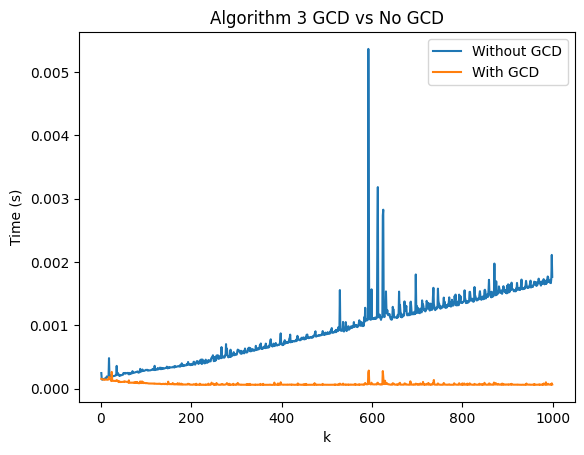

In [95]:
k_values = list(range(1, 1000))
times = []
times_gcd = []

for i, k in enumerate(k_values):
    print("Normal")
    time1, result2 = test_alg3(k)
    times.append(time1)
    print("GCD")
    time_gcd, result2_gcd = test_alg3(k, gcd=True)
    times_gcd.append(time_gcd)
    if(result2 != result2_gcd):
        print("Different results")
        break

plt.plot(k_values, times, label="Without GCD")
plt.plot(k_values, times_gcd, label="With GCD")
plt.xlabel("k")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Algorithm 3 GCD vs No GCD")

## **A test with $gcd \ne k$ and also check if the allocation is the same**

In [96]:
def test_alg3_2(k: int = 1, gcd: bool = False):
    candidates = ['A', 'B', 'C', 'D']
    p = 'C'
    entries_test2 = [
            ProfileEntry(k * 6, ['B', 'C', 'D', 'A']),
            ProfileEntry(k * 6, ['C', 'D', 'A', 'B']),
            ProfileEntry(k * 4, ['D', 'A', 'B', 'C']),
            ProfileEntry(k * 4, ['A', 'B', 'C', 'D']),
        ]
    profile_test2 = Profile(candidates, entries_test2)
    ws_test2 = [entry.count for entry in entries_test2]  
    wt_test2 = [k * 2, k * 1]
    u_test2 = 0
    start_2 = time.time()
    result2 = algorithm_3(candidates, p, profile_test2, ws_test2, wt_test2, u_test2, gcd=gcd)
    end_2 = time.time()
    return end_2 - start_2, result2

Normal
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 12
g = A
diff_g = 4
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 18
g = A
diff_g = 6
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 24
g = A
diff_g = 8
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 30
g = A
diff_g = 10
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 36
g = A
diff_g = 12
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g = A
diff_g = 2
Final weights: [1, 0]
Normal
winner = B, winner_score = 42
g = A
diff_g = 14
Final weights: [1, 0]
GCD
winner = B, winner_score = 6
g

Text(0.5, 1.0, 'Algorithm 3 GCD vs No GCD')

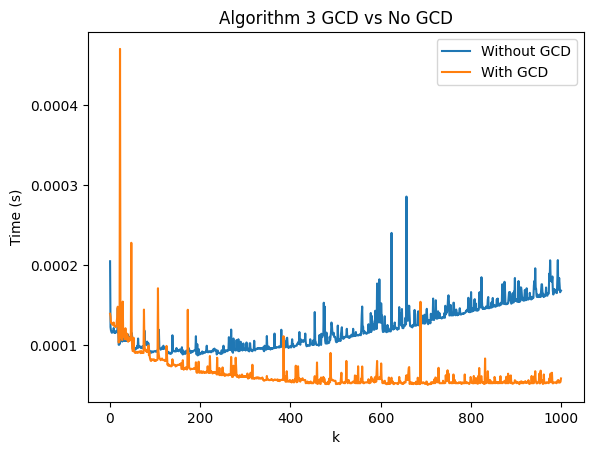

In [97]:
k_values = list(range(1, 1000))
times = []
times_gcd = []

for i, k in enumerate(k_values):
    print('Normal')
    time1, result2 = test_alg3_2(k)
    times.append(time1)
    print('GCD')
    time_gcd, result2_gcd = test_alg3_2(k, gcd=True)
    times_gcd.append(time_gcd)
    if(result2 != result2_gcd):
        print("Different results")
        break

plt.plot(k_values, times, label="Without GCD")
plt.plot(k_values, times_gcd, label="With GCD")
plt.xlabel("k")
plt.ylabel("Time (s)")
plt.legend()
plt.title("Algorithm 3 GCD vs No GCD")

## **Behavior of the Algorithm as a Function of $u$**

winner = B, winner_score = 6
g = A
diff_g = 1
Final weights: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

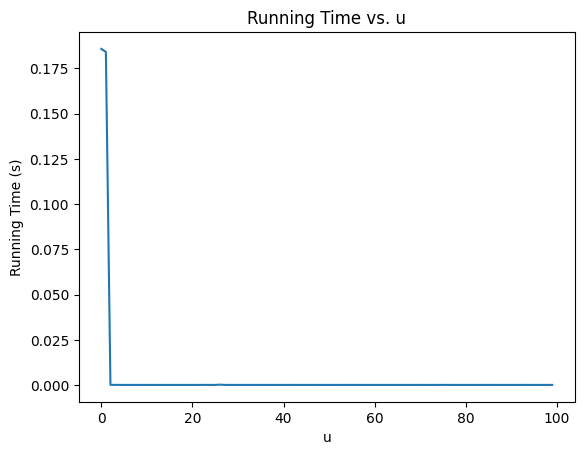

In [100]:
import time
import matplotlib.pyplot as plt

candidates = ['A', 'B', 'C', 'D']
p = 'C'  # The candidate we want to manipulate to win

# Test 2: Manipulation not possible
entries = [
    ProfileEntry(6, ['B', 'C', 'D', 'A']),
    ProfileEntry(4, ['C', 'D', 'A', 'B']),
    ProfileEntry(5, ['D', 'A', 'B', 'C']),
    ProfileEntry(5, ['A', 'B', 'C', 'D']),
]
profile = Profile(candidates, entries)
ws = [entry.count for entry in entries]  
wt = [1] * 1000 # minimal manipulation: two manipulators vote for C, one votes for A

running_times = []

for u in range(100):
    start = time.time()
    result = algorithm_3(candidates, p, profile, ws, wt, u)
    print("u: {}, Result: {}".format(u, result))
    end = time.time()
    running_times.append(end - start)

plt.plot(range(100), running_times)
plt.xlabel('u')
plt.ylabel('Running Time (s)')
plt.title('Running Time vs. u')
plt.show()